# Benchmark Comparison

This notebook compares QuASAr's native backends with external simulators from Qiskit Aer and MQT DD.

In [1]:
import json
import sys
from pathlib import Path
sys.path.append(str(Path(".." ).resolve().parent))
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


sns.set_theme()


The figure below compares execution times for QuASAr backends. A later plot shows peak memory usage for the same circuits.

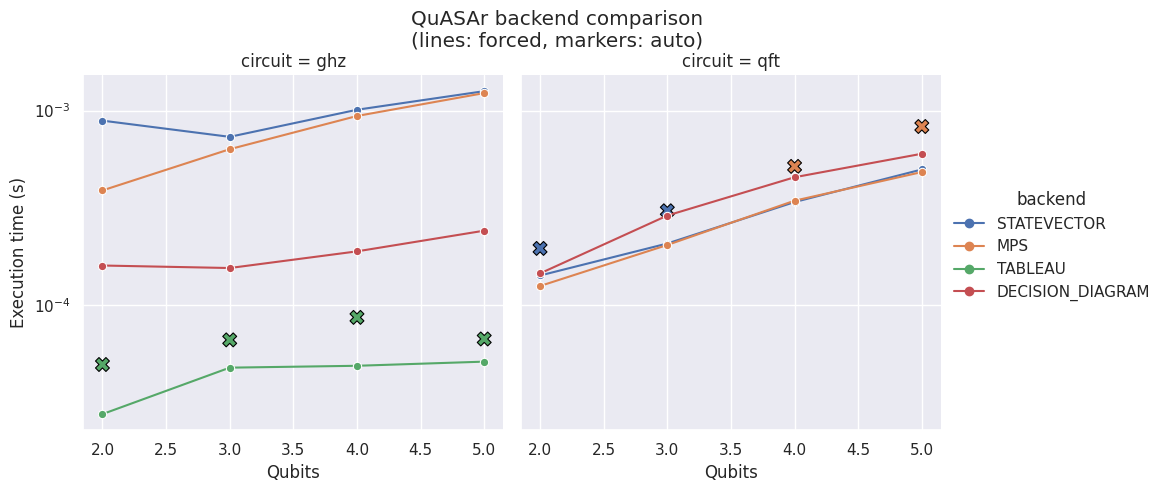

In [2]:
nb_root = Path('..').resolve()
sys.path.append(str(nb_root))
sys.path.append(str(nb_root.parent))

from runner import BenchmarkRunner
import circuits as circuit_lib
from quasar import SimulationEngine
from quasar.cost import Backend

if not hasattr(Backend, 'MQT_DD'):
    Backend.MQT_DD = Backend.DECISION_DIAGRAM

backends = [Backend.STATEVECTOR, Backend.MPS, Backend.TABLEAU, Backend.MQT_DD]
runner = BenchmarkRunner()
engine = SimulationEngine()

circuits = {
    'ghz': circuit_lib.ghz_circuit,
    'qft': circuit_lib.qft_circuit,
}

qubit_sizes = list(range(2, 6))

for name, build in circuits.items():
    for n in qubit_sizes:
        try:
            base_circ = build(n)
            base_circ.use_classical_simplification = False
        except Exception:
            continue
        for b in backends:
            try:
                rec = runner.run_quasar_multiple(base_circ, engine, backend=b, repetitions=3)
                rec.update({'circuit': name, 'qubits': n, 'mode': 'forced'})
            except Exception:
                pass
        try:
            auto_circ = build(n)
            auto_circ.use_classical_simplification = True
            rec = runner.run_quasar_multiple(auto_circ, engine, repetitions=3)
            rec.update({'circuit': name, 'qubits': n, 'mode': 'auto'})
        except Exception:
            pass

df = pd.DataFrame(runner.results)
results = df
backend_order = [b.name for b in backends]
palette = dict(zip(backend_order, sns.color_palette(n_colors=len(backend_order))))

forced = df[df['mode'] == 'forced']
auto = df[df['mode'] == 'auto']

g = sns.relplot(
    data=forced,
    x='qubits',
    y='run_time_mean',
    hue='backend',
    hue_order=backend_order,
    palette=palette,
    col='circuit',
    kind='line',
    marker='o',
)
g.set_axis_labels('Qubits', 'Execution time (s)')

for circuit_name, ax in g.axes_dict.items():
    sub = auto[auto['circuit'] == circuit_name]
    sns.scatterplot(
        data=sub,
        x='qubits',
        y='run_time_mean',
        hue='backend',
        hue_order=backend_order,
        palette=palette,
        marker='X',
        s=100,
        edgecolor='black',
        ax=ax,
        legend=False,
    )

g.set(yscale='log')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('QuASAr backend comparison\n(lines: forced, markers: auto)')
plt.show()


These results separate the **preparation** time from the actual **simulation** run time. Preparation typically includes converting circuits or planning steps, whereas simulation measures the time spent executing the circuit. The table and plot above illustrate how both components contribute to the total runtime.

The plot below shows peak memory usage for QuASAr backends. Lines represent forced mode, while markers denote automatic backend selection.

In [ ]:

forced_mem = forced.copy()
auto_mem = auto.copy()
for d in (forced_mem, auto_mem):
    d['run_peak_memory_mean_mb'] = d['run_peak_memory_mean'] / 1024 ** 2

g = sns.relplot(
    data=forced_mem,
    x='qubits',
    y='run_peak_memory_mean_mb',
    hue='backend',
    hue_order=backend_order,
    palette=palette,
    col='circuit',
    kind='line',
    marker='o',
)
g.set_axis_labels('Qubits', 'Peak memory (MiB)')
for circuit_name, ax in g.axes_dict.items():
    sub = auto_mem[auto_mem['circuit'] == circuit_name]
    sns.scatterplot(
        data=sub,
        x='qubits',
        y='run_peak_memory_mean_mb',
        hue='backend',
        hue_order=backend_order,
        palette=palette,
        marker='X',
        s=100,
        edgecolor='black',
        ax=ax,
        legend=False,
    )

g.set(yscale='log')
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('QuASAr backend peak memory comparison
(lines: forced, markers: auto)')
plt.show()


In [5]:
import pandas as pd
from benchmarks.stats_utils import stats_table

def add_stats(df, quasar_col='QuASAr', baseline_cols=None, test='ttest', correction='bonferroni'):
    """Compute statistics comparing QuASAr with baselines.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame with per-circuit results. One column must correspond to QuASAr,
        others to baselines.
    quasar_col : str
        Name of the column containing QuASAr results.
    baseline_cols : list[str] | None
        Columns to treat as baselines. Defaults to all columns except quasar_col.
    test : str
        'ttest' or 'wilcoxon'.
    correction : str
        'bonferroni' or 'fdr_bh'.

    Returns
    -------
    pd.DataFrame
        Table with baseline name, statistic, corrected p-value, and effect size.
    """
    if baseline_cols is None:
        baseline_cols = [c for c in df.columns if c != quasar_col]
    baselines = {c: df[c] for c in baseline_cols}
    return stats_table(df[quasar_col], baselines, test=test, correction=correction)

# Example usage after computing results DataFrame named `results_df`:
# stats_df = add_stats(results_df)
# stats_df


In [6]:
# Record parameters and results
import json, pathlib
try:
    import ipynbname
    nb_name = ipynbname.path().stem
except Exception:  # pragma: no cover
    nb_name = 'notebook'

# Collect simple parameters from globals
_params = {
    k: v for k, v in globals().items()
    if not k.startswith('_') and isinstance(v, (int, float, str, bool, list, dict, tuple))
}
pathlib.Path('../results').mkdir(exist_ok=True)
with open(f'../results/{nb_name}_params.json', 'w') as f:
    json.dump(_params, f, indent=2, default=str)
if 'results' in globals():
    try:
        with open(f'../results/{nb_name}_results.json', 'w') as f:
            json.dump(results, f, indent=2)
    except TypeError:
        pass
